In [21]:
import glob
import skimage
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
plt.style.use('default')

In [2]:
# Add Cascade? Need negative training data.

class Pic:
    
    C_MAP = None
    
    def __init__(self, local_file):
        self.data = skimage.io.imread(local_file)
        self.original_copy = self.data
        self.height = self.data.shape[0]
        self.width = self.data.shape[1]
        
    @classmethod
    def get_cmap(cls):
        return cls.C_MAP 
    
    def reset(self):
        self.data = self.original_copy
        return self
        
    def show_pic(self, contours = None, blobs = None):
        dpi = 200
        plt.figure(dpi = dpi)
        plt.grid(False)
        plt.imshow(self.data, cmap = self.get_cmap())
        if contours is not None:
            for contour in contours:
                plt.plot(contour[:, 1], contour[:, 0], linewidth = 1)
        ax = plt.gca()
        if blobs is not None:
            for blob in blobs:
                y, x, area = blob
                ax.add_patch(plt.Circle((x, y), area, color = 'r', fill = False, linewidth = 1))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.show()
        
    def show_hist(self):
        dpi = 200
        plt.figure(dpi = dpi)
        plt.hist(self.data.ravel(), 
                 bins = 256, 
                 histtype = 'stepfilled', 
                 color = 'darkblue',
                 edgecolor = 'black',
                 density = True)
        plt.title('Pixel Intensity Histogram')
        plt.xlim(0,1)
        plt.show()
        
    def equalize_contrast(self):
        self.data = skimage.exposure.equalize_hist(self.data)
        return self
        
    def clahe(self, clip_limit = 0.03):
        self.data = skimage.exposure.equalize_adapthist(self.data, clip_limit = clip_limit)
        return self
    
    def resize(self, output_height, output_width):
        self.data = (
            skimage.transform.resize(self.data, 
                                     output_shape = (output_height, output_width), 
                                     anti_aliasing = True)
        )
        return self
    
    def hog(self):
        if self.get_cmap() == 'gray':
            channel_axis = None
        else:
            channel_axis = -1
        _, hog_image = skimage.feature.hog(self.data, 
                                           orientations = 8, 
                                           pixels_per_cell = (16, 16),
                                           cells_per_block = (1, 1), 
                                           visualize = True,
                                           channel_axis = channel_axis)
        self.data = skimage.exposure.rescale_intensity(hog_image, 
                                                       in_range = 'image', 
                                                       out_range = (0, 50))
        return self.show_pic()

In [3]:
class ColorPic(Pic):
    
    def __init__(self, local_file):
        super().__init__(local_file)
        
    def show_rgb_hist(self):
        dpi = 200
        plt.figure(dpi = dpi)
        plt.hist(self.data[:,:,0].ravel(), bins = 256, color = 'red', alpha = 0.5, density = True)
        plt.hist(self.data[:,:,1].ravel(), bins = 256, color = 'green', alpha = 0.5, density = True)
        plt.hist(self.data[:,:,2].ravel(), bins = 256, color = 'blue', alpha = 0.5, density = True)
        plt.xlim(0,256)
        plt.title('Density of RGB Values in Picture')
        plt.show()
        
    def slic(self, n_segments = 500):
        segments = skimage.segmentation.slic(self.data, 
                                             n_segments = n_segments, 
                                             compactness = 1,
                                             sigma = 1)
        self.data = skimage.color.label2rgb(segments, self.data, kind = 'avg')
        return self

In [4]:
class GrayPic(Pic):
    
    C_MAP = 'gray'
    def __init__(self, local_file):
        super().__init__(local_file)
        if len(self.data.shape) == 3: 
            self.data = skimage.color.rgb2gray(self.data)
        else:
            self.data = self.data
        self.original_copy = self.data
        self.global_thresh = skimage.filters.threshold_otsu(self.data)
        
    def thresh(self):
        self.data = self.data > self.global_thresh
        return self
        
    def inverse_thresh(self):
        self.data = self.data <= self.global_thresh
        return self
    
    def edges(self, sigma = 0.5):
        self.data = skimage.feature.canny(self.data, sigma = sigma)
        return self
    
    def erode(self):
        self.data = skimage.morphology.binary_erosion(self.data)
        return self
    
    def dilate(self):
        self.data = skimage.morphology.binary_dilation(self.data)
        return self
    
    def close(self):
        self.data = skimage.morphology.binary_closing(self.data, np.ones((1,1)))
        return self
    
    def show_contours(self):
        contours = skimage.measure.find_contours(self.thresh().data)
        return self.show_pic(contours = contours)
      
    def show_blobs(self):
        blobs = skimage.feature.blob_doh(self.thresh().close().data)
        return self.show_pic(blobs = blobs)
    
    def watershed(self):
        edges = skimage.filters.sobel(self.data)
        markers = np.zeros_like(self.data)
        foreground, background = 1, 2
        markers[self.data <= np.quantile(self.data, 0.25)] = background
        markers[self.data > np.quantile(self.data, 0.25)] = foreground

        ws = skimage.segmentation.watershed(edges, markers)
        segments = skimage.measure.label(ws == foreground)
        segments_colors = skimage.color.label2rgb(segments, image = self.data, bg_label = 0)
        
        plt.grid(False)
        plt.imshow(segments_colors)
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.show()

In [5]:
class PicCollection:
    
    def __init__(self, ls_of_pics):
        self.collection = []
        for i in ls_of_pics:
            if isinstance(i, Pic):
                self.collection.append(i)
            else:
                raise ValueError("PicCollection must contain a Picture!")
        self.sizes = {i: i.height * i.width for i in self.collection}
        self.min_size_object = sorted(self.sizes.items(), 
                                      key = lambda x: x[1])[0]
        self.max_size_object = sorted(self.sizes.items(), 
                                      key = lambda x: x[1],
                                      reverse = True)[0]
        
    def resize_collection(self, min_or_max = 'min'):
        if min_or_max == 'max':
            output_height = output_width = np.sqrt(self.max_size_object[1])
        else:
            output_height = output_width = np.sqrt(self.min_size_object[1])
        self.resized_collection = (
            [i.resize(output_height = output_height, 
                      output_width = output_width) for i in self.collection]
        )
        return self

In [6]:
collection = PicCollection([GrayPic(i) for i in glob.glob('data/original_pictures/*.jpg')])

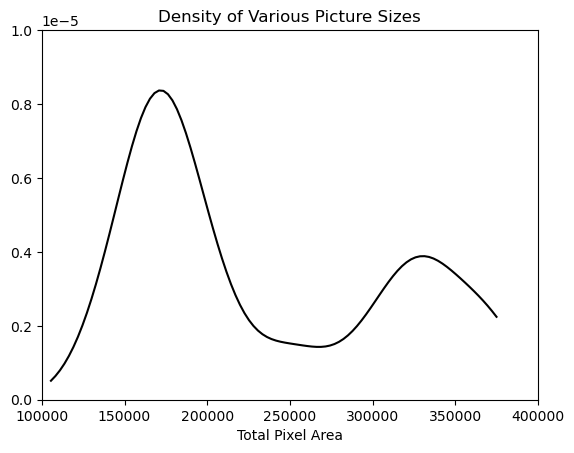

In [33]:
various_sizes = list(collection.sizes.values())

density = gaussian_kde(various_sizes)
min_size = np.min(various_sizes)
max_size = np.max(various_sizes)
density.covariance_factor = lambda : .25
density._compute_covariance()
xs = np.linspace(min_size, max_size, num = 100)
plt.plot(xs, density(xs), c = 'black')
plt.xlim(100000,400000)
plt.ylim(0, 10e-6)
plt.title('Density of Various Picture Sizes')
plt.xlabel('Total Pixel Area')
plt.show();

In [9]:
# Extra code. May use later.

#     def haar(self):
#         haar_coords, _ = skimage.feature.haar_like_feature_coord(self.height, 
#                                                                  self.width, 
#                                                                  'type-4')
#         haar = skimage.feature.draw_haar_like_feature(self.data,
#                                                       0, 0,
#                                                       self.height,
#                                                       self.width,
#                                                       haar_coords,
#                                                       max_n_features = 1)
#         return haar